In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Ερώτημα 1: Feedforward Neural Network

Βήμα 1: Φόρτωση δεδομένων (mfccs)

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Το path στον φάκελο
folder = "/content/gdrive/MyDrive/Anagnwrish_Protupwn/music_genre_data_di"

X_train_mfccs_path = folder + "/train/mfccs/X.npy"
X_labels_train_mfccs_path = folder + "/train/mfccs/labels.npy"

X_val_mfccs_path = folder + "/val/mfccs/X.npy"
X_labels_val_mfccs_path = folder + "/val/mfccs/labels.npy"

X_test_mfccs_path = folder + "/test/mfccs/X.npy"
X_labels_test_mfccs_path = folder + "/test/mfccs/labels.npy"

X_train = np.load(X_train_mfccs_path)
Y_train = np.load(X_labels_train_mfccs_path)
X_val = np.load(X_val_mfccs_path)
Y_val = np.load(X_labels_val_mfccs_path)
X_test = np.load(X_test_mfccs_path)
Y_test = np.load(X_labels_test_mfccs_path)

# Dictionary για strings σε ακέραιους
label_mapping = {
    "blues": 0,
    "classical": 1,
    "hiphop": 2,
    "rock_metal_hardrock": 3
}

# Αντικατάσταση των strings με τους αντίστοιχους ακεραιους
Y_train = np.array([label_mapping[label] for label in Y_train])
Y_val = np.array([label_mapping[label] for label in Y_val])
Y_test = np.array([label_mapping[label] for label in Y_test])

# Torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# TensorDatasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# DataLoaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Έλεγχος των DataLoaders
for X_batch, Y_batch in train_loader:
    print(X_batch.shape, Y_batch.shape)
    break

for X_batch, Y_batch in val_loader:
    print(X_batch.shape, Y_batch.shape)
    break

for X_batch, Y_batch in test_loader:
    print(X_batch.shape, Y_batch.shape)
    break

torch.Size([16, 26]) torch.Size([16])
torch.Size([16, 26]) torch.Size([16])
torch.Size([16, 26]) torch.Size([16])


Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [ ]:
# Ορισμός Νευρωνικού Δικτύου
import torch.nn as nn

class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Δημιουργία του μοντέλου
input_size = 26  # Διάσταση εισόδου
hidden1_size = 128  # Πρώτο κρυφό επίπεδο με 128 νευρώνες
hidden2_size = 32  # Δεύτερο κρυφό επίπεδο με 32 νευρώνες
output_size = 4  # Έξοδος με 4 κλάσεις

model = FullyConnectedNN(input_size, hidden1_size, hidden2_size, output_size)

# Εκτύπωση της δομής του μοντέλου
print(model)

FullyConnectedNN(
  (fc1): Linear(in_features=26, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Συνάρτηση εκπαίδευσης
def train_model(model, train_loader, loss_func, optimizer, num_epochs, device):
    model.to(device)  # Σε περίπτωση που τρέχει στην GPU
    for epoch in range(num_epochs):
        model.train()  # Θέτει το μοντέλο σε κατάσταση εκπαίδευσης

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device) # Σε περίπτωση που τρέχει στην GPU

            # Μηδενισμός των gradients
            optimizer.zero_grad()

            # Υπολογισμός εξόδου του μοντέλου
            outputs = model(inputs)

            # Υπολογισμός του loss
            loss = loss_func(outputs, labels)

            # Backward pass και ενημέρωση των βαρών
            loss.backward()
            optimizer.step()

            # Συγκέντρωση του loss
            running_loss += loss.item()

        # Εκτύπωση του μέσου loss για κάθε epoch
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model


Βήμα 4: Ορισμός διαδικασίας αξιολόγησης

In [ ]:
import torch
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def evaluate_model(model, val_loader, loss_func, device):
    model.eval()  # Θέτει το μοντέλο σε κατάσταση αξιολόγησης
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Απενεργοποιεί την καταγραφή των gradients
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Σε περίπτωση που τρέχει στην GPU

            # Υπολογισμός εξόδου του μοντέλου
            outputs = model(inputs)

            # Υπολογισμός του loss
            loss = loss_func(outputs, labels)
            val_loss += loss.item()

            # Υπολογισμός των προβλέψεων
            _, preds = torch.max(outputs, 1)  # Επιλέγω τις max πιθανότητες
            all_preds.extend(preds.cpu().numpy()) # Το .cpu() το βάζω σε περίπτωση που τρέχει στην GPU
            all_labels.extend(labels.cpu().numpy()) # Το .cpu() το βάζω σε περίπτωση που τρέχει στην GPU

    # Υπολογισμός του μέσου loss
    avg_loss = val_loss / len(val_loader)

    # Υπολογισμός του f1-score, accuracy και confusion matrix
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_loss, f1, accuracy, conf_matrix


Βήμα 5: Εκπαίδευση δικτύου

In [ ]:
import torch
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Ορισμός υπερπαραμέτρων
learning_rate = 0.002
num_epochs = 30

model = FullyConnectedNN(input_size, hidden1_size, hidden2_size, output_size)

# Ορισμός συνάρτησης κόστους και optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Εκπαίδευση του μοντέλου
model = train_model(model, train_loader, loss_func, optimizer, num_epochs, device=torch.device('cpu'))

# Αξιολόγηση του μοντέλου στο test set
test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(model, test_loader, loss_func, device=torch.device('cpu'))

print(f'Test Loss: {test_loss:.4f}')
print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_conf_matrix)


Epoch 1/30, Loss: 1.3963
Epoch 2/30, Loss: 1.3708
Epoch 3/30, Loss: 1.3488
Epoch 4/30, Loss: 1.3228
Epoch 5/30, Loss: 1.3020
Epoch 6/30, Loss: 1.2743
Epoch 7/30, Loss: 1.2468
Epoch 8/30, Loss: 1.2202
Epoch 9/30, Loss: 1.1886
Epoch 10/30, Loss: 1.1655
Epoch 11/30, Loss: 1.1340
Epoch 12/30, Loss: 1.1099
Epoch 13/30, Loss: 1.0881
Epoch 14/30, Loss: 1.0714
Epoch 15/30, Loss: 1.0532
Epoch 16/30, Loss: 1.0403
Epoch 17/30, Loss: 1.0229
Epoch 18/30, Loss: 1.0071
Epoch 19/30, Loss: 0.9956
Epoch 20/30, Loss: 0.9884
Epoch 21/30, Loss: 0.9755
Epoch 22/30, Loss: 0.9705
Epoch 23/30, Loss: 0.9599
Epoch 24/30, Loss: 0.9572
Epoch 25/30, Loss: 0.9427
Epoch 26/30, Loss: 0.9457
Epoch 27/30, Loss: 0.9331
Epoch 28/30, Loss: 0.9349
Epoch 29/30, Loss: 0.9364
Epoch 30/30, Loss: 0.9251
Test Loss: 0.9564
Test F1 Score (Macro Averaged): 0.6092
Test Accuracy: 0.6047
Test Confusion Matrix:
[[162  31  38  93]
 [ 34 242   5  16]
 [145  16 169  26]
 [ 78  35  27 259]]


Βήμα 6: Εκπαίδευση δικτύου με GPU

In [ ]:
import torch
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import time

# Ορισμός υπερπαραμέτρων
learning_rate = 0.002
num_epochs = 30

model_cpu = FullyConnectedNN(input_size, hidden1_size, hidden2_size, output_size)

# Ορισμός συνάρτησης κόστους και optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cpu.parameters(), lr=learning_rate)

# Χρόνος εκπαίδευσης στη CPU
start_time_cpu = time.time()
model_cpu = train_model(model_cpu, train_loader, loss_func, optimizer, num_epochs, device=torch.device('cpu'))
end_time_cpu = time.time()
cpu_training_time = end_time_cpu - start_time_cpu

# Μεταφορά του μοντέλου και των δεδομένων στη συσκευή (GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Χρόνος εκπαίδευσης στη GPU
model_gpu = FullyConnectedNN(input_size, hidden1_size, hidden2_size, output_size)  # Νέα αρχικοποίηση του μοντέλου
optimizer = optim.SGD(model_gpu.parameters(), lr=learning_rate)  # Νέα αρχικοποίηση του optimizer

start_time_gpu = time.time()
model_gpu = train_model(model_gpu, train_loader, loss_func, optimizer, num_epochs, device)
end_time_gpu = time.time()
gpu_training_time = end_time_gpu - start_time_gpu

print(f'CPU Training Time: {cpu_training_time:.2f} seconds')
print(f'GPU Training Time: {gpu_training_time:.2f} seconds')

# Αξιολόγηση του μοντέλου στο test set
test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(model_gpu, test_loader, loss_func, device)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_conf_matrix)


Βήμα 7: Επιλογή μοντέλου

Τα αποτελέσματα είναι εμφανώς καλύτερα όπως φαίνεται στις μετρήσεις.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Συνάρτηση εκπαίδευσης
def train_model(model, train_loader, val_loader, loss_func, optimizer, num_epochs, device):
    best_f1 = 0.0
    best_model = None

    model.to(device)  # Σε περίπτωση που τρέχει στην GPU
    for epoch in range(num_epochs):
        model.train()  # Θέτει το μοντέλο σε κατάσταση εκπαίδευσης

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device) # Σε περίπτωση που τρέχει στην GPU

            # Μηδενισμός των gradients
            optimizer.zero_grad()

            # Υπολογισμός εξόδου του μοντέλου
            outputs = model(inputs)

            # Υπολογισμός του loss
            loss = loss_func(outputs, labels)

            # Backward pass και ενημέρωση των βαρών
            loss.backward()
            optimizer.step()

            # Συγκέντρωση του loss
            running_loss += loss.item()

        # Εκτύπωση του μέσου loss για κάθε epoch
        epoch_loss = running_loss / len(train_loader)

        # Αξιολόγηση στο validation set
        _, val_f1, _, _ = evaluate_model(model, val_loader, loss_func, device)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation F1: {val_f1:.4f}')

        # Αν είναι το βέλτιστο μοντέλο, κρατάμε αυτό
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model.state_dict().copy()

    # Φόρτωση του βέλτιστου μοντέλου
    model.load_state_dict(best_model)
    return model

# Ορισμός υπερπαραμέτρων
learning_rate = 0.002
num_epochs = 30

model = FullyConnectedNN(input_size, hidden1_size, hidden2_size, output_size)

# Ορισμός συνάρτησης κόστους και optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Μεταφορά του μοντέλου και των δεδομένων στη συσκευή (GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Εκπαίδευση του μοντέλου
model = train_model(model, train_loader, val_loader, loss_func, optimizer, num_epochs, device)

# Αξιολόγηση του μοντέλου στο test set
test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(model, test_loader, loss_func, device)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_conf_matrix)



Epoch 1/30, Loss: 1.3711, Validation F1: 0.2453
Epoch 2/30, Loss: 1.3441, Validation F1: 0.1433
Epoch 3/30, Loss: 1.3257, Validation F1: 0.3276
Epoch 4/30, Loss: 1.3030, Validation F1: 0.2860
Epoch 5/30, Loss: 1.2805, Validation F1: 0.3599
Epoch 6/30, Loss: 1.2537, Validation F1: 0.4748
Epoch 7/30, Loss: 1.2252, Validation F1: 0.5714
Epoch 8/30, Loss: 1.1986, Validation F1: 0.3758
Epoch 9/30, Loss: 1.1675, Validation F1: 0.5254
Epoch 10/30, Loss: 1.1421, Validation F1: 0.5553
Epoch 11/30, Loss: 1.1131, Validation F1: 0.4787
Epoch 12/30, Loss: 1.0950, Validation F1: 0.6162
Epoch 13/30, Loss: 1.0787, Validation F1: 0.6185
Epoch 14/30, Loss: 1.0588, Validation F1: 0.5954
Epoch 15/30, Loss: 1.0385, Validation F1: 0.5096
Epoch 16/30, Loss: 1.0235, Validation F1: 0.5179
Epoch 17/30, Loss: 1.0119, Validation F1: 0.5953
Epoch 18/30, Loss: 0.9961, Validation F1: 0.6194
Epoch 19/30, Loss: 0.9931, Validation F1: 0.6374
Epoch 20/30, Loss: 0.9832, Validation F1: 0.5942
Epoch 21/30, Loss: 0.9662, Va

# Ερώτημα 2: Convolutional Neural Network

Βήμα 1: Φόρτωση δεδομένων (spectrograms)

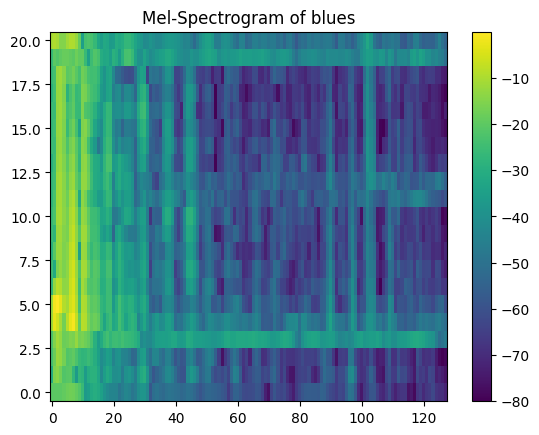

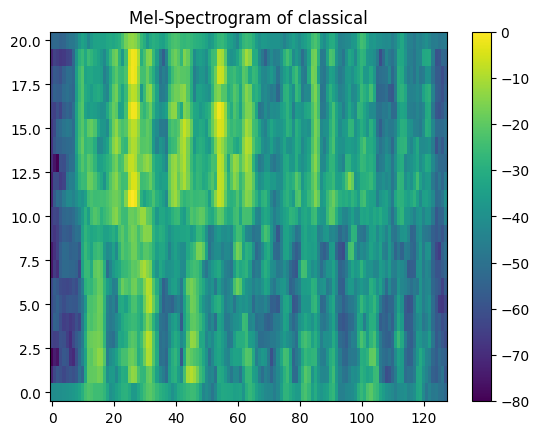

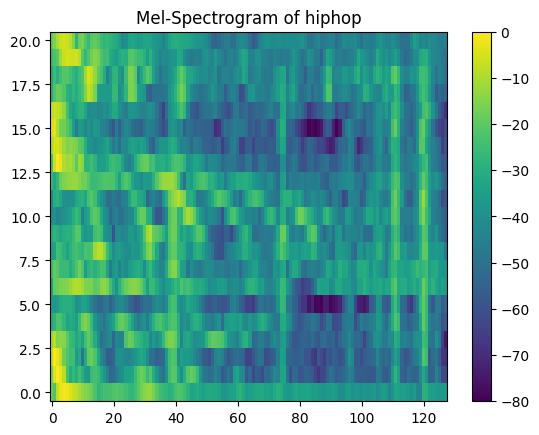

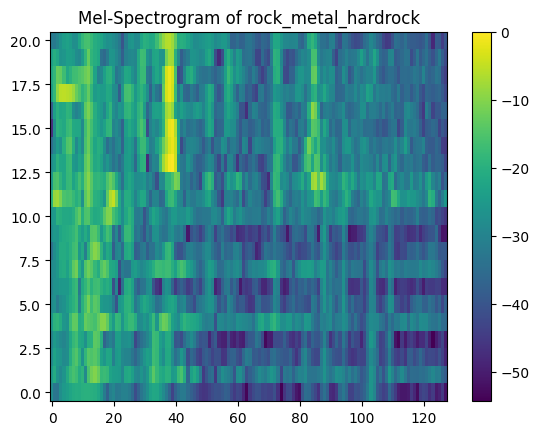

torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])


In [10]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Το path του φακέλου
folder = "/content/gdrive/MyDrive/Anagnwrish_Protupwn/music_genre_data_di"

X_train_melgrams_path = folder + "/train/melgrams/X.npy"
X_labels_train_melgrams_path = folder + "/train/melgrams/labels.npy"

X_val_melgrams_path = folder + "/val/melgrams/X.npy"
X_labels_val_melgrams_path = folder + "/val/melgrams/labels.npy"

X_test_melgrams_path = folder + "/test/melgrams/X.npy"
X_labels_test_melgrams_path = folder + "/test/melgrams/labels.npy"

# Φόρτωση των δεδομένων
X_train = np.load(X_train_melgrams_path)
Y_train = np.load(X_labels_train_melgrams_path)
X_val = np.load(X_val_melgrams_path)
Y_val = np.load(X_labels_val_melgrams_path)
X_test = np.load(X_test_melgrams_path)
Y_test = np.load(X_labels_test_melgrams_path)

# Dictionary για strings σε ακέραιους
label_mapping = {
    "blues": 0,
    "classical": 1,
    "hiphop": 2,
    "rock_metal_hardrock": 3
}

# Αντικατάσταση των strings με τους αντίστοιχους ακεραιους
Y_train = np.array([label_mapping[label] for label in Y_train])
Y_val = np.array([label_mapping[label] for label in Y_val])
Y_test = np.array([label_mapping[label] for label in Y_test])

# Torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Προσθήκη διάστασης καναλιού
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)  # Προσθήκη διάστασης καναλιού
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Προσθήκη διάστασης καναλιού
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# TensorDatasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# DataLoaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Οπτικοποίηση ενός τυχαίου mel-spectrogram από κάθε κλάση
def plot_melgram(melgram, label):
    plt.imshow(melgram, aspect='auto', origin='lower')
    plt.title(f'Mel-Spectrogram of {label}')
    plt.colorbar()
    plt.show()

# Επιλογή τυχαίων δειγμάτων για κάθε κλάση και οπτικοποίηση
for label_str, label_num in label_mapping.items():
    idx = np.where(Y_train == label_num)[0][0]  # Επιλογή του πρώτου δείγματος για την κλάση αυτή
    melgram = X_train[idx]
    plot_melgram(melgram, label_str)

# Έλεγχος των DataLoaders
for X_batch, Y_batch in train_loader:
    print(X_batch.shape, Y_batch.shape)
    break

for X_batch, Y_batch in val_loader:
    print(X_batch.shape, Y_batch.shape)
    break

for X_batch, Y_batch in test_loader:
    print(X_batch.shape, Y_batch.shape)
    break


Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [ ]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_channels=1, out_dim=4):
        super(CNN, self).__init__()

        # Συνελικτικά επίπεδα
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5)

        # Υπολογισμός της διάστασης της εξόδου του τελευταίου συνελικτικού επιπέδου
        # Η αρχική διάσταση είναι 21x128 και μειώνεται κατά 4 (5-1) σε κάθε διάσταση μετά από κάθε συνελικτικό επίπεδο
        conv_output_size = 21 - 4 * 4  # 21 - 4 * 4 = 5 (5 διαστάσεις του χρόνου)
        freq_output_size = 128 - 4 * 4  # 128 - 4 * 4 = 112 (112 διαστάσεις της συχνότητας)
        self.fc1_input_dim = 128 * conv_output_size * freq_output_size  # 128 * 5 * 112 = 71680

        # Πλήρως συνδεδεμένα επίπεδα
        self.fc1 = nn.Linear(self.fc1_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):
        # Συνελικτικά επίπεδα
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Πλήρως συνδεδεμένα επίπεδα
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

# Δημιουργία του μοντέλου
input_channels = 1
out_dim = 4  # Αριθμός εξόδων (κλάσεις)

model = CNN(input_channels, out_dim)

# Εκτύπωση της δομής του μοντέλου
print(model)


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=71680, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)


Βήμα 3: Εκπαίδευση δικτύου

Τα δεδομένα πριν εφαρμόσω αλλαγές, δεν μπορούσαν να γίνουν train λόγω πρόβλημα διαστάσεων. Για αυτο εφαρμόζω την αλλαγή στην φόρτωση των δεδομένων (βήμα 1) κατά την οποία με την μέθοδο unsqueeze προσθέτω μια διάσταση στα δεδομένα για να μπορεί να γινει το training.
Μετα την αλλαγη πάλι δεν μπορουσαν να γίνουν train λόγω του μεγάλου learning rate. Μόλις το μείωσα σε 0.001 μπορεσε να εκπαιδευτει.
Παρατηρώ ότι το μοντέλο είναι μέτριο εώς κακό μέχρι τώρα. Το Loss του test set ήταν υψηλό (3 και κατι) και το Accuracy χαμηλό (0.4 και κάτι). Αυτό, και η διαφορά μεταξύ του f1 στο training και του f1 στο test, υποδηλώνουν ότι το μοντέλο δεν μπορεί να γενικεύσει καλά και υποθέτω (χωρίς να είμαι βέβαιος) ότι μάλλον κάνει overfitting. Παρατηρώ επίσης μια σύγχιση στο confusion matrix, δείχνοντας πάλι ότι δυσκολεύεται να διακρίνει σε σωστές κλάσεις.

Η διαφορά CPU με GPU αυτή τη φορά είναι πραγματικά φανερή, αφού το μοντέλο με CPU έτρεχε περίπου 1 ώρα και 15 λεπτά, ενώ με GPU έτρεχε περίπου 2 λεπτά και λίγα δευτερόλεπτα! Εντυπωσιακά μεγαλύτερη αναλογία χρόνου CPU / χρόνου GPU!

In [11]:
# Συνάρτηση εκπαίδευσης
# Όπως λέει η σημείωση στην εκφώνηση, χρησιμοποιώ το validation set για να αποφασίσω ποιο μοντέλο θα κρατήσω.

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Αξιολόγηση μοντέλου
def evaluate_model(model, val_loader, loss_func, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_loss, f1, accuracy, conf_matrix

# Εκπαίδευση μοντέλου
def train_model(model, train_loader, val_loader, loss_func, optimizer, num_epochs, device):
    best_f1 = 0.0
    best_model = None

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        _, val_f1, _, _ = evaluate_model(model, val_loader, loss_func, device)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation F1: {val_f1:.4f}')

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model.state_dict().copy()

    model.load_state_dict(best_model)
    return model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Ορισμός των παραμέτρων εκπαίδευσης
num_epochs = 30
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()

model_cpu = CNN(input_channels, out_dim)

optimizer = optim.SGD(model_cpu.parameters(), lr=learning_rate)

# Εκπαίδευση του μοντέλου στη CPU
start_time_cpu = time.time()
model_cpu = train_model(model_cpu, train_loader, val_loader, loss_func, optimizer, num_epochs, device=torch.device('cpu'))
end_time_cpu = time.time()
cpu_training_time = end_time_cpu - start_time_cpu

model_gpu = CNN(input_channels, out_dim)

optimizer = optim.SGD(model_gpu.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Εκπαίδευση του μοντέλου στη GPU
start_time_gpu = time.time()
model_gpu = train_model(model_gpu, train_loader, val_loader, loss_func, optimizer, num_epochs, device)
end_time_gpu = time.time()
gpu_training_time = end_time_gpu - start_time_gpu

print(f'CPU Training Time: {cpu_training_time:.2f} seconds')
print(f'GPU Training Time: {gpu_training_time:.2f} seconds')

# Αξιολόγηση του εκπαιδευμένου μοντέλου στο test set
test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(model_gpu, test_loader, loss_func, device)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_conf_matrix)


Epoch 1/30, Loss: 1.3658, Validation F1: 0.5161
Epoch 2/30, Loss: 0.9955, Validation F1: 0.6075
Epoch 3/30, Loss: 0.8332, Validation F1: 0.6232
Epoch 4/30, Loss: 0.7675, Validation F1: 0.6092
Epoch 5/30, Loss: 0.7064, Validation F1: 0.6267
Epoch 6/30, Loss: 0.6656, Validation F1: 0.5872
Epoch 7/30, Loss: 0.6257, Validation F1: 0.6106
Epoch 8/30, Loss: 0.6018, Validation F1: 0.5973
Epoch 9/30, Loss: 0.5655, Validation F1: 0.5961
Epoch 10/30, Loss: 0.5265, Validation F1: 0.6014
Epoch 11/30, Loss: 0.4951, Validation F1: 0.5876
Epoch 12/30, Loss: 0.4686, Validation F1: 0.5836
Epoch 13/30, Loss: 0.4354, Validation F1: 0.5528
Epoch 14/30, Loss: 0.4001, Validation F1: 0.5880
Epoch 15/30, Loss: 0.3719, Validation F1: 0.5724
Epoch 16/30, Loss: 0.3467, Validation F1: 0.5820
Epoch 17/30, Loss: 0.3119, Validation F1: 0.5720
Epoch 18/30, Loss: 0.2901, Validation F1: 0.5616
Epoch 19/30, Loss: 0.2601, Validation F1: 0.5572
Epoch 20/30, Loss: 0.2302, Validation F1: 0.5365
Epoch 21/30, Loss: 0.2041, Va

Βήμα 4: Pooling and padding

Χρησιμότητα του max pooling:
Όπως είπαμε και στο μάθημα, το max pooling πέρα από την προφανή χρησιμότητα του που είναι η μείωση διαστάσεων και άρα την υπολογιστική πολυπλοκότητα, βοηθάει στο να δώσει το μοντέλο έμφαση στις θετικές συσχετίσεις, και μάλιστα στις μεγαλύτερες συσχετίσεις των δεδομένων. Εφόσον θέλουμε να ταξινομήσουμε τα δεδομένα, μας βοηθάει να δούμε πως συσχετίζονται ΘΕΤΙΚΑ και μας ενδιαφέρουν οι μεγάλες συσχετίσεις. Άρα γενικα, μας βοηθάει στην αποφυγή overfitting, στη μείωση διαστάσεων και μείωση υπολογιστικής πολυπλοκότητας, και κρατάει τις πιο σημαντικές για εμάς πληροφορίες, αγνοώντας τις λιγότερο σημαντικές.

Χρησιμότητα του padding:
Μας βοηθά στο να κρατήσουμε την πληροφορία στις άκρες της εισόδου, που χωρίς το padding πιθανόν να χανόταν. Επίσης, φέρνει μια ισορροπία στη μείωση διαστάσεων του max pooling, αφού βοηθάει να μην μειωθούν τραγικά οι διαστάσεις των δεδομένων μετά από κάθε συνελικτικό επίπεδο.

Επιδόσεις:
Παρατηρώ ότι το μοντέλο αυτό με πολύ λιγότερο χρόνο καταφέρνει να γενικεύει καλύτερα και άρα να πετυχαίνει καλύτερα αποτελέσματα. Το Test loss του είναι πολύ χαμηλότερο από πριν (0.8 περίπου) ενώ το accuracy του πολύ υψηλότερο από πριν (0.7 περίπου). Ακόμη παρατηρώ κάποια σύγχιση στο confusion matrix αλλά μικρότερη σε σχέση με πριν.

Χρόνος απόδοσης:
Όταν τα παραπάνω τα συνδιάσουμε και με την εξοικονόμηση χρόνου που πετυχαίνουμε το μοντέλο αυτό αποδεικνύεται μακράν καλύτερο. Με CPU έτρεξε σε μόλις 10 λεπτά, ενώ με GPU μόλις σε !

Άρα είναι πολύ πιο γρήγορο και αποδοτικότερο από το προηγούμενο μοντέλο.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import time

class MaxPoolingCNN(nn.Module):
    def __init__(self, input_channels=1, out_dim=4):
        super(MaxPoolingCNN, self).__init__()

        # Συνελικτικά επίπεδα με padding 2 και max pooling με kernel size 2
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Υπολογισμός της διάστασης της εξόδου του τελευταίου συνελικτικού επιπέδου
        conv_output_size = 21 // 16  # 21 μειώνεται σε 1 μετά από 4 επίπεδα pooling (διαίρεση με 2 τέσσερις φορές)
        freq_output_size = 128 // 16  # 128 μειώνεται σε 8 μετά από 4 επίπεδα pooling (διαίρεση με 2 τέσσερις φορές)
        self.fc1_input_dim = 128 * conv_output_size * freq_output_size  # 128 * 1 * 8 = 1024

        # Πλήρως συνδεδεμένα επίπεδα
        self.fc1 = nn.Linear(self.fc1_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):
        # Συνελικτικά επίπεδα με pooling
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))

        # Flatten
        x = x.view(x.size(0), -1)

        # Πλήρως συνδεδεμένα επίπεδα
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

input_channels = 1
out_dim = 4  # Αριθμός εξόδων (κλάσεις)

# Ορισμός των παραμέτρων εκπαίδευσης
num_epochs = 30
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()

# Δημιουργία του μοντέλου
maxpool_model_cpu = MaxPoolingCNN(input_channels, out_dim)

# Εκτύπωση της δομής του μοντέλου
print(maxpool_model_cpu)

optimizer = optim.SGD(maxpool_model_cpu.parameters(), lr=learning_rate)

# Εκπαίδευση του μοντέλου στη CPU
start_time_cpu = time.time()
maxpool_model_cpu = train_model(maxpool_model_cpu, train_loader, val_loader, loss_func, optimizer, num_epochs, device=torch.device('cpu'))
end_time_cpu = time.time()
cpu_training_time = end_time_cpu - start_time_cpu

# Δημιουργία του μοντέλου
maxpool_model_gpu = MaxPoolingCNN(input_channels, out_dim)

# Εκτύπωση της δομής του μοντέλου
print(maxpool_model_gpu)

optimizer = optim.SGD(maxpool_model_gpu.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU

# Εκπαίδευση του μοντέλου στη GPU
start_time_gpu = time.time()
maxpool_model_gpu = train_model(maxpool_model_gpu, train_loader, val_loader, loss_func, optimizer, num_epochs, device)
end_time_gpu = time.time()
gpu_training_time = end_time_gpu - start_time_gpu

print(f'GPU Training Time: {cpu_training_time:.2f} seconds')
print(f'GPU Training Time: {gpu_training_time:.2f} seconds')

# Αξιολόγηση του εκπαιδευμένου μοντέλου στο test set
test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(maxpool_model_gpu, test_loader, loss_func, device)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_conf_matrix)


MaxPoolingCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)
Epoch 1/30, Loss: 1.3615, Validation F1: 0.3251
Epoch 2/30, Loss: 1.2869, Validation

Βήμα 5: Activation functions

Η απόδοση του μοντέλου αφού εφάρμοσα την ReLU όσον αφορά το learning rate ίσο με 0.001 ήταν χειρότερη, αφού χωρίς την ReLU είχα υψηλότερο accuracy (0.7 και κάτι) και χαμηλότερο loss (0.8 περίπου) και με την ReLU έχω accuracy = 0.62 και loss = 0.9. Δοκίμασα πολλά learning rates. Με learning rate = 0.005 το accuracy ισούται με 0.7 αλλά το loss ισούται με περίπου 1.3. Με learning rate = 0.01 το accuracy πάλι είναι 0.7 και το loss είναι 1.13 περίπου.

Άρα με την ReLU γενικότερα πετυχαίνω χειρότερες αποδόσεις. Η χειρότερη απόδοση φαίνεται και στο confusion matrix.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

class ReluCNN(nn.Module):
    def __init__(self, input_channels=1, out_dim=4):
        super(ReluCNN, self).__init__()

        # Συνελικτικά επίπεδα με padding 2 και max pooling με kernel size 2
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Υπολογισμός της διάστασης της εξόδου του τελευταίου συνελικτικού επιπέδου
        conv_output_size = 21 // 16  # 21 μειώνεται σε 1 μετά από 4 επίπεδα pooling (διαίρεση με 2 τέσσερις φορές)
        freq_output_size = 128 // 16  # 128 μειώνεται σε 8 μετά από 4 επίπεδα pooling (διαίρεση με 2 τέσσερις φορές)
        self.fc1_input_dim = 128 * conv_output_size * freq_output_size  # 128 * 1 * 8 = 1024

        # Πλήρως συνδεδεμένα επίπεδα
        self.fc1 = nn.Linear(self.fc1_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):
        # Συνελικτικά επίπεδα με ReLU και pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Πλήρως συνδεδεμένα επίπεδα με ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

input_channels = 1
out_dim = 4  # Αριθμός εξόδων (κλάσεις)

# Ορισμός των παραμέτρων εκπαίδευσης
num_epochs = 30
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()

# Δημιουργία του μοντέλου
relu_model = ReluCNN(input_channels, out_dim)

# Εκτύπωση της δομής του μοντέλου
print(relu_model)

optimizer = optim.SGD(relu_model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU

# Εκπαίδευση του μοντέλου στη GPU
relu_model = train_model(relu_model, train_loader, val_loader, loss_func, optimizer, num_epochs, device)

# Αξιολόγηση του εκπαιδευμένου μοντέλου στο test set
test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(relu_model, test_loader, loss_func, device)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_conf_matrix)


ReluCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)
Epoch 1/30, Loss: 1.3849, Validation F1: 0.1000
Epoch 2/30, Loss: 1.3806, Validation F1: 0

# Ερώτημα 3: Improving Performance

Συναρτήσεις που θα χρησιμοποιώ και η κλάση ReluCNN:

In [14]:
import os
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# Φόρτωση των melgrams
def create_data(music_genre_path, batch_size):
    X_train_melgrams_path = music_genre_path + "/train/melgrams/X.npy"
    X_labels_train_melgrams_path = music_genre_path + "/train/melgrams/labels.npy"

    X_val_melgrams_path = music_genre_path + "/val/melgrams/X.npy"
    X_labels_val_melgrams_path = music_genre_path + "/val/melgrams/labels.npy"

    X_test_melgrams_path = music_genre_path + "/test/melgrams/X.npy"
    X_labels_test_melgrams_path = music_genre_path + "/test/melgrams/labels.npy"

    # Φόρτωση των δεδομένων
    X_train = np.load(X_train_melgrams_path)
    Y_train = np.load(X_labels_train_melgrams_path)
    X_val = np.load(X_val_melgrams_path)
    Y_val = np.load(X_labels_val_melgrams_path)
    X_test = np.load(X_test_melgrams_path)
    Y_test = np.load(X_labels_test_melgrams_path)

    # Δημιουργία ενός dictionary για strings σε ακέραιους
    label_mapping = {
        "blues": 0,
        "classical": 1,
        "hiphop": 2,
        "rock_metal_hardrock": 3
    }

    # Αντικατάσταση των strings με τους αντίστοιχους ακεραιους
    Y_train = np.array([label_mapping[label] for label in Y_train])
    Y_val = np.array([label_mapping[label] for label in Y_val])
    Y_test = np.array([label_mapping[label] for label in Y_test])

    # Torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Προσθήκη διάστασης καναλιού
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)  # Προσθήκη διάστασης καναλιού
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Προσθήκη διάστασης καναλιού
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

    # TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Έλεγχος των DataLoaders
    for X_batch, Y_batch in train_loader:
        print(X_batch.shape, Y_batch.shape)
        break

    for X_batch, Y_batch in val_loader:
        print(X_batch.shape, Y_batch.shape)
        break

    for X_batch, Y_batch in test_loader:
        print(X_batch.shape, Y_batch.shape)
        break

    return train_loader, val_loader, test_loader

# Το νευρωνικό δίκτυο
class ReluCNN(nn.Module):
    def __init__(self, input_channels=1, out_dim=4):
        super(ReluCNN, self).__init__()

        # Συνελικτικά επίπεδα με padding 2 και max pooling με kernel size 2
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Υπολογισμός της διάστασης της εξόδου του τελευταίου συνελικτικού επιπέδου
        conv_output_size = 21 // 16  # 21 μειώνεται σε 1 μετά από 4 επίπεδα pooling (διαίρεση με 2 τέσσερις φορές)
        freq_output_size = 128 // 16  # 128 μειώνεται σε 8 μετά από 4 επίπεδα pooling (διαίρεση με 2 τέσσερις φορές)
        self.fc1_input_dim = 128 * conv_output_size * freq_output_size  # 128 * 1 * 8 = 1024

        # Πλήρως συνδεδεμένα επίπεδα
        self.fc1 = nn.Linear(self.fc1_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):
        # Συνελικτικά επίπεδα με ReLU και pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Πλήρως συνδεδεμένα επίπεδα με ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

# Αξιολόγηση μοντέλου
def evaluate_model(model, val_loader, loss_func, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_loss, f1, accuracy, conf_matrix

# Εκπαίδευση μοντέλου
def train_model(model, train_loader, val_loader, loss_func, optimizer, num_epochs, device):
    best_f1 = 0.0
    best_model = None

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        _, val_f1, _, _ = evaluate_model(model, val_loader, loss_func, device)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation F1: {val_f1:.4f}')

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model.state_dict().copy()

    model.load_state_dict(best_model)
    return model

# Ορισμός των seeds για αναπαραγωγικότητα
def set_seed(seed=3):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Ορισμός του PYTHONHASHSEED
    os.environ["PYTHONHASHSEED"] = str(seed)


Βήμα 1: Reproducibility

Πήρα βοήθεια από το σάιτ: https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy

Πράγματι, το έτρεξα δύο φορές και έβγαλε τα ίδια αποτελέσματα.

In [15]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim

# Ορισμός των seeds για αναπαραγωγικότητα
def set_seed(seed=3):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Ορισμός του PYTHONHASHSEED
    os.environ["PYTHONHASHSEED"] = str(seed)

# Θέση σε seed για αναπαραγωγικότητα
seed = 3
set_seed(seed)

input_channels = 1
out_dim = 4  # Αριθμός εξόδων (κλάσεις)

# Ορισμός των μονοπατιών για τα αρχεία .npy των mel-spectrograms
music_genre_path = "/content/gdrive/MyDrive/Anagnwrish_Protupwn/music_genre_data_di"  # Το μονοπάτι μου
batch_size = 16

train_loader, val_loader, test_loader = create_data(music_genre_path, batch_size)

# Ορισμός των παραμέτρων εκπαίδευσης
num_epochs = 30
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()

# Δημιουργία του μοντέλου μου
relu_model1 = ReluCNN(input_channels, out_dim)

optimizer1 = optim.SGD(relu_model1.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU

# Εκπαίδευση του μοντέλου στη GPU
relu_model1 = train_model(relu_model1, train_loader, val_loader, loss_func, optimizer1, num_epochs, device)

# Αξιολόγηση του εκπαιδευμένου μοντέλου στο test set
test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(relu_model1, test_loader, loss_func, device)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_conf_matrix)


torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
Epoch 1/30, Loss: 1.3832, Validation F1: 0.2219
Epoch 2/30, Loss: 1.3776, Validation F1: 0.2239
Epoch 3/30, Loss: 1.3720, Validation F1: 0.2649
Epoch 4/30, Loss: 1.3635, Validation F1: 0.2953
Epoch 5/30, Loss: 1.3460, Validation F1: 0.2730
Epoch 6/30, Loss: 1.3039, Validation F1: 0.2726
Epoch 7/30, Loss: 1.2388, Validation F1: 0.3941
Epoch 8/30, Loss: 1.2006, Validation F1: 0.2869
Epoch 9/30, Loss: 1.1738, Validation F1: 0.3917
Epoch 10/30, Loss: 1.1389, Validation F1: 0.3915
Epoch 11/30, Loss: 1.1142, Validation F1: 0.4065
Epoch 12/30, Loss: 1.0897, Validation F1: 0.4863
Epoch 13/30, Loss: 1.0731, Validation F1: 0.4514
Epoch 14/30, Loss: 1.0556, Validation F1: 0.4994
Epoch 15/30, Loss: 1.0382, Validation F1: 0.5115
Epoch 16/30, Loss: 1.0259, Validation F1: 0.5166
Epoch 17/30, Loss: 1.0134, Validation F1: 0.3888
Epoch 18/30, Loss: 1.0027, Validation 

Βήμα 2: Αλγόριθμοι βελτιστοποίησης

Επιδόσεις:
Φαίνεται πως ο SGD δεν ήταν ο καλύτερος optimizer στην περίπτωση μας και πως οι άλλοι optimizers δούλεψαν καλύτερα και στη γενίκευση και την εκμάθηση των δεδομένων. Με καλύτερο optimizer τον Adagrad, ακολουθούν ο Adam, Adamax και τέλος ο RMSprop. Το accuracy και το f1 έχουν σημαντική διαφορά αφού στο SGD ήταν 0.59/0.58 αντίστοιχα, ενώ στο RMSprop ήταν 0.69/0.70 και στα υπόλοιπα ήταν και τα δύο πάνω από 0.7 με καλύτερο το Adagrad που έφτανε τα 0.73 και στα δύο.

In [16]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# Θέση σε seed για αναπαραγωγικότητα
seed = 3
set_seed(seed)

def fix_optimizer(model, learning_rate):
    optimizer = None
    if opt_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif opt_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif opt_name == "Adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    elif opt_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif opt_name == "Adamax":
        optimizer = optim.Adamax(model.parameters(), lr=learning_rate)

    return optimizer

input_channels = 1
out_dim = 4  # Αριθμός εξόδων (κλάσεις)

# Ορισμός των μονοπατιών για τα αρχεία .npy των melgrams
music_genre_path = "/content/gdrive/MyDrive/Anagnwrish_Protupwn/music_genre_data_di"

# Ορισμός των υπερπαραμέτρων
batch_size = 16
num_epochs = 30
learning_rate = 0.001

# Ορισμός της συσκευής (GPU ή CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Δημιουργία των DataLoader για τα train, val και test sets
train_loader, val_loader, test_loader = create_data(music_genre_path, batch_size)

# Ορισμός του loss function
loss_func = nn.CrossEntropyLoss()

# Λίστα των αλγορίθμων βελτιστοποίησης προς δοκιμή
optimizers = ["SGD", "Adam", "Adagrad", "RMSprop", "Adamax"]

# Πίνακας για καταγραφή των αποτελεσμάτων
results = {
    "Optimizer": [],
    "Accuracy": [],
    "F1 Score": []
}

model = ReluCNN(input_channels, out_dim)  # Δημιουργία νέου μοντέλου για κάθε optimizer
model.to(device)
# Εκπαίδευση και αξιολόγηση για κάθε optimizer
for opt_name in optimizers:
    print(f"Training with optimizer: {opt_name}")

    optimizer = fix_optimizer(model, learning_rate) # Φτιάχνει τον optimizer ανάλογα με το όνομα

    trained_model = train_model(model, train_loader, val_loader, loss_func, optimizer, num_epochs, device)
    _, f1, accuracy, _ = evaluate_model(trained_model, test_loader, loss_func, device)

    results["Optimizer"].append(opt_name)
    results["Accuracy"].append(accuracy)
    results["F1 Score"].append(f1)

# Δημιουργία πίνακα αποτελεσμάτων
results_df = pd.DataFrame(results)
print(results_df)


torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
Training with optimizer: SGD
Epoch 1/30, Loss: 1.3832, Validation F1: 0.2219
Epoch 2/30, Loss: 1.3776, Validation F1: 0.2239
Epoch 3/30, Loss: 1.3720, Validation F1: 0.2649
Epoch 4/30, Loss: 1.3635, Validation F1: 0.2953
Epoch 5/30, Loss: 1.3460, Validation F1: 0.2730
Epoch 6/30, Loss: 1.3039, Validation F1: 0.2726
Epoch 7/30, Loss: 1.2388, Validation F1: 0.3941
Epoch 8/30, Loss: 1.2006, Validation F1: 0.2869
Epoch 9/30, Loss: 1.1738, Validation F1: 0.3917
Epoch 10/30, Loss: 1.1389, Validation F1: 0.3915
Epoch 11/30, Loss: 1.1142, Validation F1: 0.4065
Epoch 12/30, Loss: 1.0897, Validation F1: 0.4863
Epoch 13/30, Loss: 1.0731, Validation F1: 0.4514
Epoch 14/30, Loss: 1.0556, Validation F1: 0.4994
Epoch 15/30, Loss: 1.0382, Validation F1: 0.5115
Epoch 16/30, Loss: 1.0259, Validation F1: 0.5166
Epoch 17/30, Loss: 1.0134, Validation F1: 0.3888
Epoch 18/

Βήμα 3: Batch Normalization

Επέλεξα τον optimizer Adagrad, επειδή στο προηγούμενο βήμα δούλεψε καλύτερα για το μοντέλο μας. Υπάρχει όντως βελτιωμένη απόδοση στο μοντέλο μας σε όλες τις μετρικές και στο confusion matrix.

In [17]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Το νέο νευρωνικό δίκτυο
class BatchNormalizationCNN(nn.Module):
    def __init__(self, input_channels=1, out_dim=4):
        super(BatchNormalizationCNN, self).__init__()

        # Συνελικτικά επίπεδα με padding 2, max pooling με kernel size 2 και batch normalization
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Υπολογισμός της διάστασης της εξόδου του τελευταίου συνελικτικού επιπέδου
        conv_output_size = 21 // 16  # 21 μειώνεται σε 1 μετά από 4 επίπεδα pooling (διαίρεση με 2 τέσσερις φορές)
        freq_output_size = 128 // 16  # 128 μειώνεται σε 8 μετά από 4 επίπεδα pooling (διαίρεση με 2 τέσσερις φορές)
        self.fc1_input_dim = 128 * conv_output_size * freq_output_size  # 128 * 1 * 8 = 1024

        # Πλήρως συνδεδεμένα επίπεδα
        self.fc1 = nn.Linear(self.fc1_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):
        # Συνελικτικά επίπεδα με ReLU, pooling και batch normalization
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Flatten
        x = x.view(x.size(0), -1)

        # Πλήρως συνδεδεμένα επίπεδα με ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

# Θέση σε seed για αναπαραγωγικότητα
seed = 3
set_seed(seed)

input_channels = 1
out_dim = 4  # Αριθμός εξόδων (κλάσεις)

# Ορισμός των μονοπατιών για τα αρχεία .npy των melgrams
music_genre_path = "/content/gdrive/MyDrive/Anagnwrish_Protupwn/music_genre_data_di"

# Ορισμός των υπερπαραμέτρων
batch_size = 16
num_epochs = 30
learning_rate = 0.001

# Ορισμός της συσκευής (GPU ή CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Δημιουργία των DataLoader για τα train, val και test sets
train_loader, val_loader, test_loader = create_data(music_genre_path, batch_size)

# Ορισμός του loss function
loss_func = nn.CrossEntropyLoss()

model_bn = BatchNormalizationCNN(input_channels, out_dim)  # Δημιουργία μοντέλου
model_bn.to(device)

optimizer = optim.Adagrad(model_bn.parameters(), lr=learning_rate)

trained_model_bn = train_model(model_bn, train_loader, val_loader, loss_func, optimizer, num_epochs, device)
test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(trained_model_bn, test_loader, loss_func, device)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_conf_matrix)


torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
Epoch 1/30, Loss: 0.8723, Validation F1: 0.7656
Epoch 2/30, Loss: 0.5911, Validation F1: 0.7665
Epoch 3/30, Loss: 0.5242, Validation F1: 0.7946
Epoch 4/30, Loss: 0.4690, Validation F1: 0.7778
Epoch 5/30, Loss: 0.4264, Validation F1: 0.8069
Epoch 6/30, Loss: 0.3884, Validation F1: 0.7747
Epoch 7/30, Loss: 0.3433, Validation F1: 0.7876
Epoch 8/30, Loss: 0.3072, Validation F1: 0.7931
Epoch 9/30, Loss: 0.2890, Validation F1: 0.7741
Epoch 10/30, Loss: 0.2445, Validation F1: 0.7928
Epoch 11/30, Loss: 0.2137, Validation F1: 0.8051
Epoch 12/30, Loss: 0.1873, Validation F1: 0.7907
Epoch 13/30, Loss: 0.1634, Validation F1: 0.7597
Epoch 14/30, Loss: 0.1409, Validation F1: 0.7685
Epoch 15/30, Loss: 0.1176, Validation F1: 0.7784
Epoch 16/30, Loss: 0.0980, Validation F1: 0.7788
Epoch 17/30, Loss: 0.0846, Validation F1: 0.7528
Epoch 18/30, Loss: 0.0732, Validation 

Βήμα 4: Regularization

In [18]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DropoutCNN(nn.Module):
    def __init__(self, input_channels=1, out_dim=4, dropout_p=0.5):
        super(DropoutCNN, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        conv_output_size = 21 // 16
        freq_output_size = 128 // 16
        self.fc1_input_dim = 128 * conv_output_size * freq_output_size

        # Πλήρως συνδεδεμένα επίπεδα με dropout
        self.fc1 = nn.Linear(self.fc1_input_dim, 1024)
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(1024, 256)
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(256, 32)
        self.dropout3 = nn.Dropout(p=dropout_p)
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)

        return x

# Θέση σε seed για αναπαραγωγικότητα
seed = 3
set_seed(seed)

input_channels = 1
out_dim = 4  # Αριθμός εξόδων (κλάσεις)

weight_decay = [1e-2, 1e-3, 1e-4] # Πίνακας τιμών weight decay

# Ορισμός των μονοπατιών για τα αρχεία .npy των melgrams
music_genre_path = "/content/gdrive/MyDrive/Anagnwrish_Protupwn/music_genre_data_di"

# Ορισμός των υπερπαραμέτρων
batch_size = 16
num_epochs = 60
learning_rate = 0.001

# Ορισμός της συσκευής (GPU ή CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Δημιουργία των DataLoader για τα train, val και test sets
train_loader, val_loader, test_loader = create_data(music_genre_path, batch_size)

# Ορισμός του loss function
loss_func = nn.CrossEntropyLoss()
model_wd = BatchNormalizationCNN(input_channels, out_dim)  # Δημιουργία νέου μοντέλου για κάθε optimizer
model_wd.to(device)

# Ξεχωριστή δοκιμή των weight_decays
print('Weight decays experiments:')
for wd in weight_decay:
    print(f'Weight Decay = {wd}')
    optimizer = optim.Adagrad(model_wd.parameters(), lr=learning_rate, weight_decay=wd)

    trained_model = train_model(model_wd, train_loader, val_loader, loss_func, optimizer, num_epochs, device)
    test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(trained_model, test_loader, loss_func, device)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print('Test Confusion Matrix:')
    print(test_conf_matrix)

dropout_ps = [0.25, 0.5, 0.7] # Πίνακας τιμών dropouts

# Ξεχωριστή δοκιμή των dropouts
print('Dropout percentage experiments:')
for dp in dropout_ps:
    print(f'Dropout percentage = {dp}')
    model_dp = DropoutCNN(input_channels, out_dim, dp)
    model_dp.to(device)

    optimizer = optim.Adagrad(model_dp.parameters(), lr=learning_rate)

    trained_model = train_model(model_dp, train_loader, val_loader, loss_func, optimizer, num_epochs, device)
    test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(trained_model, test_loader, loss_func, device)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print('Test Confusion Matrix:')
    print(test_conf_matrix)

# Ταυτόχρονη δοκιμή dropout και weight decay
print('Dropout percentage and Weight decays experiments:')
for dp in dropout_ps:
  for wd in weight_decay:
    print(f'Dropout percentage = {dp} and Weight Decay = {wd}')
    model_dp = DropoutCNN(input_channels, out_dim, dp)
    model_dp.to(device)

    optimizer = optim.Adagrad(model_dp.parameters(), lr=learning_rate, weight_decay=wd)

    trained_model = train_model(model_dp, train_loader, val_loader, loss_func, optimizer, num_epochs, device)
    test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(trained_model, test_loader, loss_func, device)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test F1 Score (Macro Averaged): {test_f1:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print('Test Confusion Matrix:')
    print(test_conf_matrix)


torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
Weight decays experiments:
Weight Decay = 0.01
Epoch 1/60, Loss: 0.8724, Validation F1: 0.7540
Epoch 2/60, Loss: 0.6034, Validation F1: 0.7665
Epoch 3/60, Loss: 0.5390, Validation F1: 0.8003
Epoch 4/60, Loss: 0.4894, Validation F1: 0.7847
Epoch 5/60, Loss: 0.4492, Validation F1: 0.8040
Epoch 6/60, Loss: 0.4109, Validation F1: 0.7855
Epoch 7/60, Loss: 0.3679, Validation F1: 0.7919
Epoch 8/60, Loss: 0.3340, Validation F1: 0.8032
Epoch 9/60, Loss: 0.3172, Validation F1: 0.7822
Epoch 10/60, Loss: 0.2724, Validation F1: 0.7960
Epoch 11/60, Loss: 0.2390, Validation F1: 0.7993
Epoch 12/60, Loss: 0.2118, Validation F1: 0.7968
Epoch 13/60, Loss: 0.1862, Validation F1: 0.7559
Epoch 14/60, Loss: 0.1603, Validation F1: 0.7729
Epoch 15/60, Loss: 0.1330, Validation F1: 0.7734
Epoch 16/60, Loss: 0.1140, Validation F1: 0.7899
Epoch 17/60, Loss: 0.0986, Validation F1

# Ερώτημα 4: Testing

Το μοντέλο που θα χρησιμοποιηθεί στο ερώτημα 4.

In [19]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DropoutCNN(nn.Module):
    def __init__(self, input_channels=1, out_dim=4, dropout_p=0.5):
        super(DropoutCNN, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        conv_output_size = 21 // 16
        freq_output_size = 128 // 16
        self.fc1_input_dim = 128 * conv_output_size * freq_output_size

        # Πλήρως συνδεδεμένα επίπεδα με dropout
        self.fc1 = nn.Linear(self.fc1_input_dim, 1024)
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(1024, 256)
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(256, 32)
        self.dropout3 = nn.Dropout(p=dropout_p)
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)

        return x

Βήμα 1: Inference

In [20]:
def get_predictions(dataloader, model, device):
    model.eval()  # Βάζουμε το μοντέλο σε κατάσταση αξιολόγησης
    predictions = []

    with torch.no_grad():
        for batch in dataloader:  # Δεν μας ενδιαφέρουν οι ετικέτες εδώ
            inputs = batch[0].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Παίρνουμε τις προβλέψεις
            predictions.extend(preds.cpu().numpy())  # Μετατρέπουμε τις προβλέψεις σε numpy και τις προσθέτουμε στη λίστα

    return predictions

Βήμα 2: Κατέβασμα μουσικής από το youtube

In [21]:
!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl
!python3 -m pip install -U yt-dlp #youtube-dl has not been updated for some years and
                                  #does not work anymore, so we use an alternative

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,450 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,390 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/m

In [22]:
# Step 1: Install the necessary libraries
!pip install pytube pydub

# Step 2: Import the libraries
from pytube import YouTube
from pydub import AudioSegment
import os

def download_youtube(url):
    command = f'yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" ' + url + " --quiet"
    os.system(command)

import librosa
import numpy as np

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21

def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("temp.wav")
    np.save("melgrams.npy", melgrams)
    os.remove("temp.wav")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.6 MB/s eta 0:00:00


Βήμα 3: Προβλέψεις

Διάλεξα το μοντέλο με Dropout = 0.5 και weight decay = 0.0001 λόγω καλών αποτελεσμάτων στο προηγούμενο ερώτημα.

Οι προβλέψεις ήταν πολύ καλές ειδικά στην κλασσική μουσική και το ροκ και το χιπχοπ. Ήταν επίσης καλές και στο μπλουζ αλλά όχι τόσο όσο στα υπόλοιπα. Φαίνεται πως το μοντέλο θα μπορούσε να προβλέψει καλά το είδος μουσικής σε ένα τραγούδι. Παρατήρησα κιόλας ότι όταν σε κάποια σημεία ενός τραγουδιού μοιάζει με άλλο είδος μουσικής τότε αυτό φαίνεται στο διάγραμμα (ας πουμε το Yellow Tape πριν τα 13 δευτερολεπτα μοιάζει όντως με μπλουζ/κλασσική μουσικη).

In [23]:
# Εκπαιδεύω το μοντέλο του ερωτήματος 4

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Θέση σε seed για αναπαραγωγικότητα
seed = 3
set_seed(seed)

# Ορισμός των μονοπατιών για τα αρχεία .npy των melgrams
music_genre_path = "/content/gdrive/MyDrive/Anagnwrish_Protupwn/music_genre_data_di"

input_channels = 1
out_dim = 4  # Αριθμός εξόδων (κλάσεις)

# Ορισμός των υπερπαραμέτρων
batch_size = 16
num_epochs = 60
learning_rate = 0.001

# Ορισμός της συσκευής (GPU ή CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Δημιουργία των DataLoader για τα train, val και test sets
train_loader, val_loader, _ = create_data(music_genre_path, batch_size)

# Ορισμός του loss function
loss_func = nn.CrossEntropyLoss()

dp = 0.5

model = DropoutCNN(input_channels, out_dim, dp)
model.to(device)

weight_decay = 0.0001

optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Εκπαιδεύουμε το μοντέλο μας για να κάνουμε προβλέψεις
trained_model = train_model(model, train_loader, val_loader, loss_func, optimizer, num_epochs, device)

torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
torch.Size([16, 1, 21, 128]) torch.Size([16])
Epoch 1/60, Loss: 1.1873, Validation F1: 0.6568
Epoch 2/60, Loss: 0.9361, Validation F1: 0.7201
Epoch 3/60, Loss: 0.8071, Validation F1: 0.7758
Epoch 4/60, Loss: 0.7353, Validation F1: 0.7601
Epoch 5/60, Loss: 0.6896, Validation F1: 0.7629
Epoch 6/60, Loss: 0.6382, Validation F1: 0.7770
Epoch 7/60, Loss: 0.6018, Validation F1: 0.7836
Epoch 8/60, Loss: 0.5788, Validation F1: 0.7801
Epoch 9/60, Loss: 0.5513, Validation F1: 0.7872
Epoch 10/60, Loss: 0.5141, Validation F1: 0.7739
Epoch 11/60, Loss: 0.5029, Validation F1: 0.7927
Epoch 12/60, Loss: 0.4897, Validation F1: 0.7799
Epoch 13/60, Loss: 0.4442, Validation F1: 0.7698
Epoch 14/60, Loss: 0.4299, Validation F1: 0.7704
Epoch 15/60, Loss: 0.4188, Validation F1: 0.7967
Epoch 16/60, Loss: 0.3848, Validation F1: 0.8138
Epoch 17/60, Loss: 0.3842, Validation F1: 0.7818
Epoch 18/60, Loss: 0.3738, Validation 

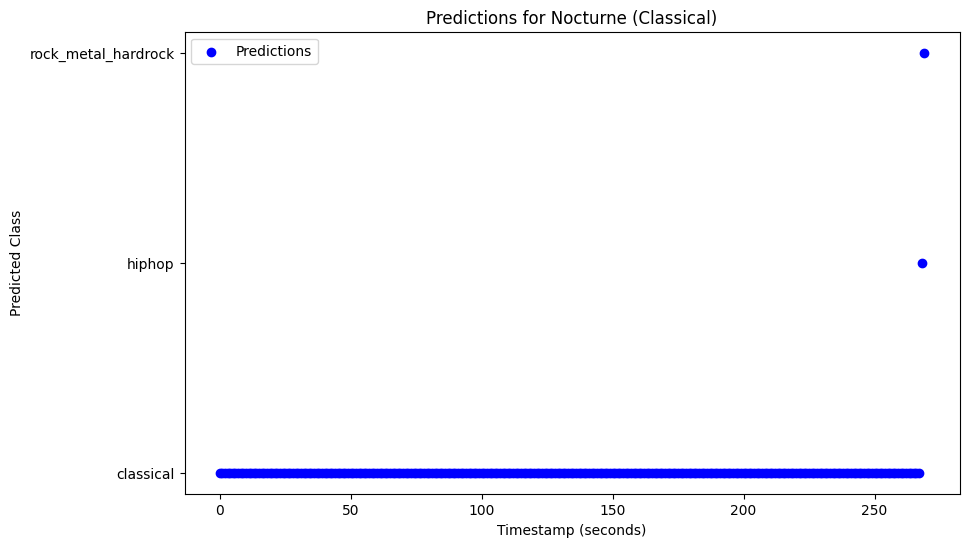

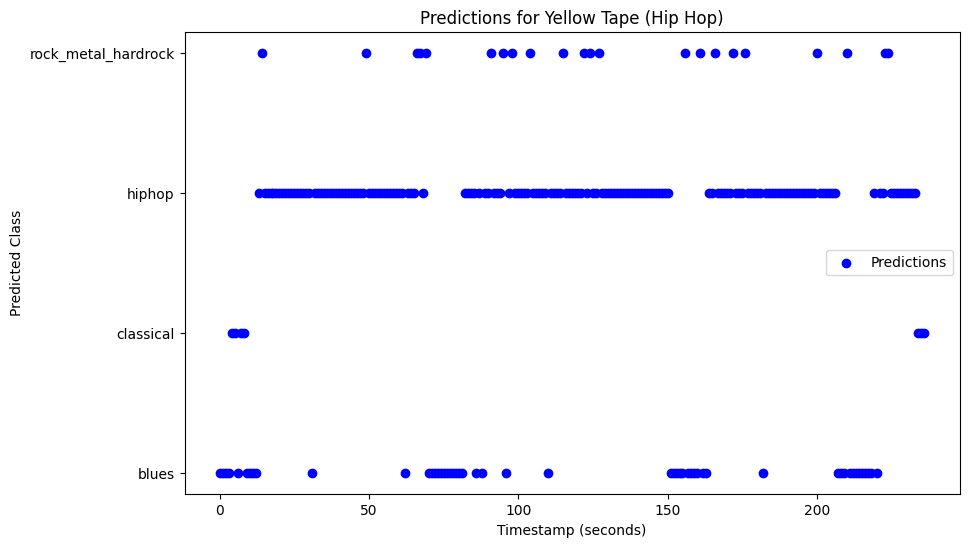

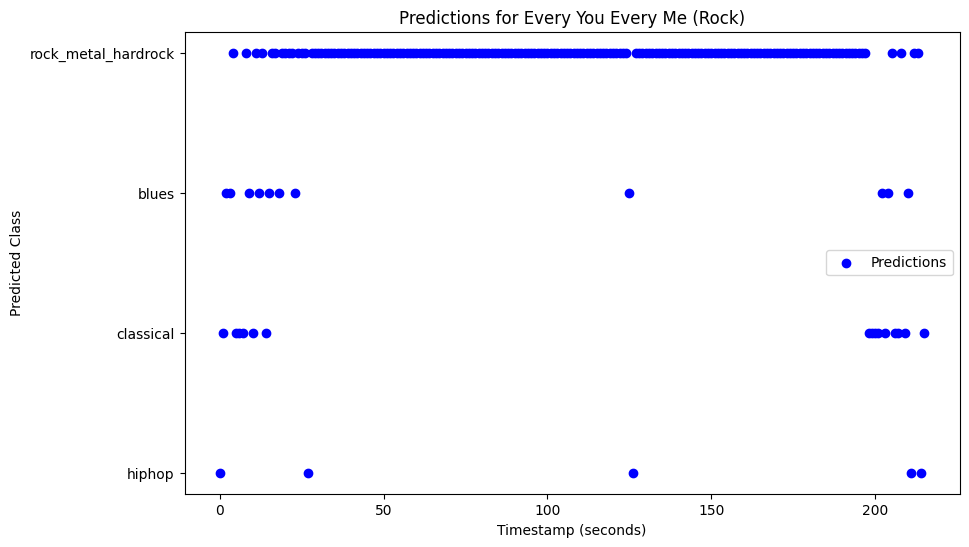

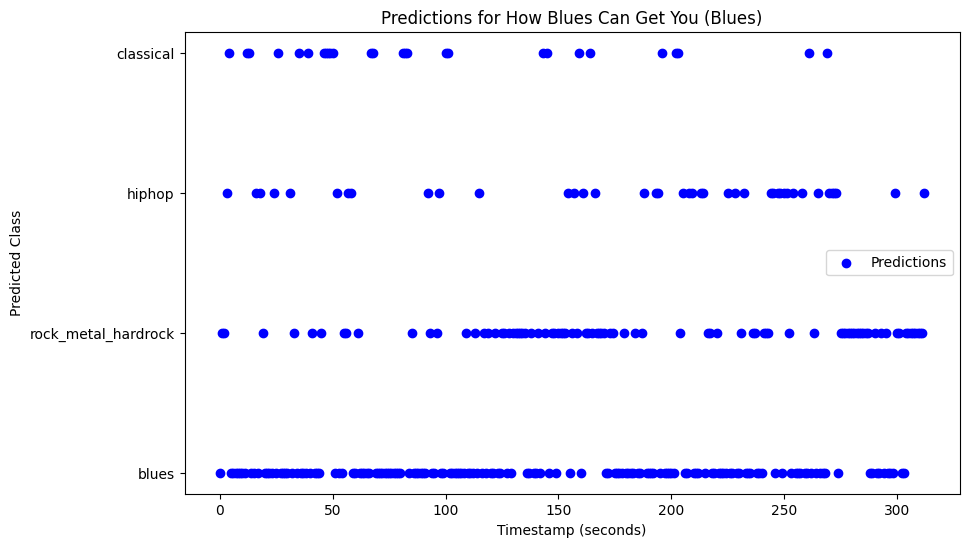

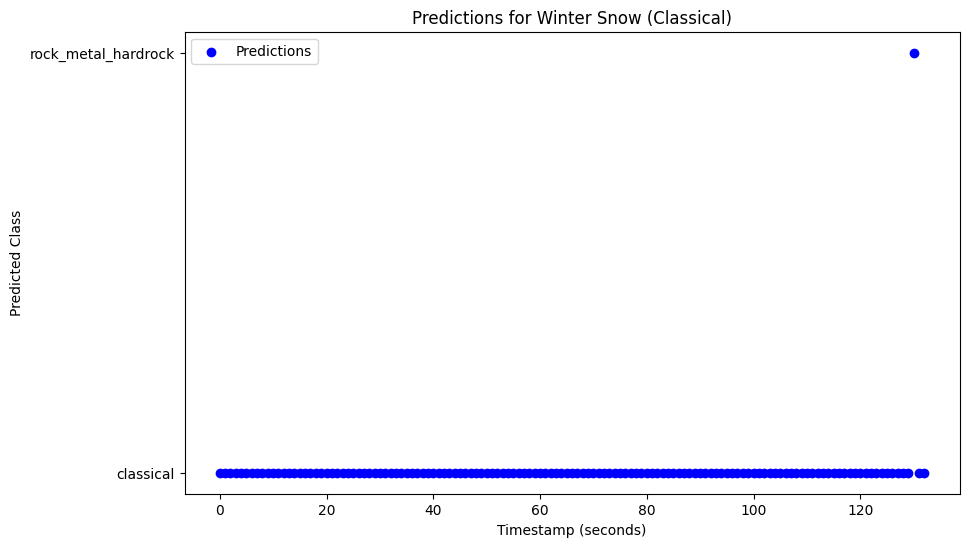

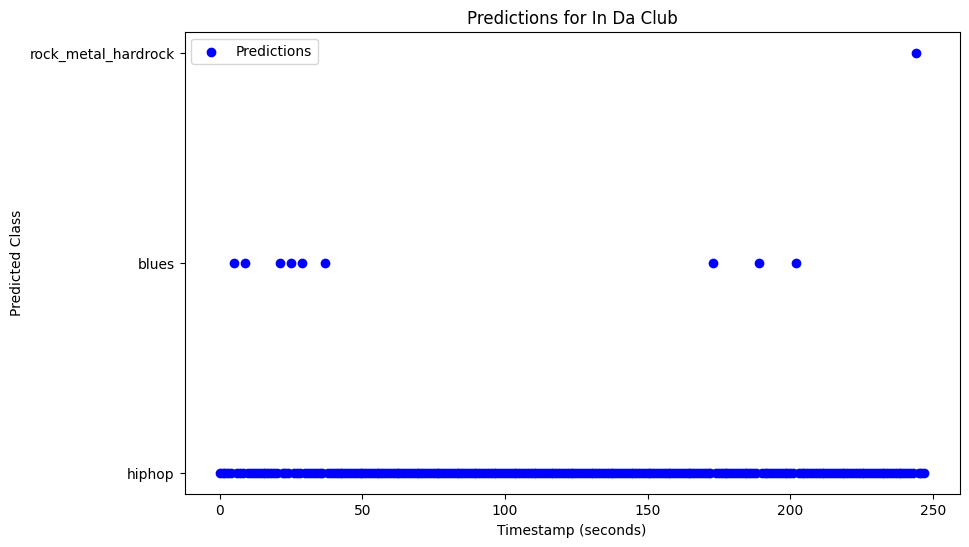

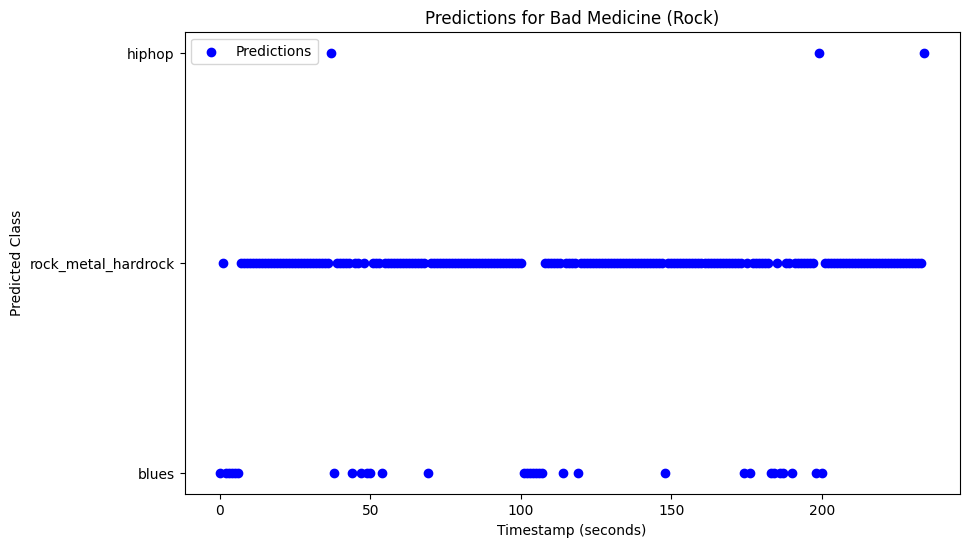

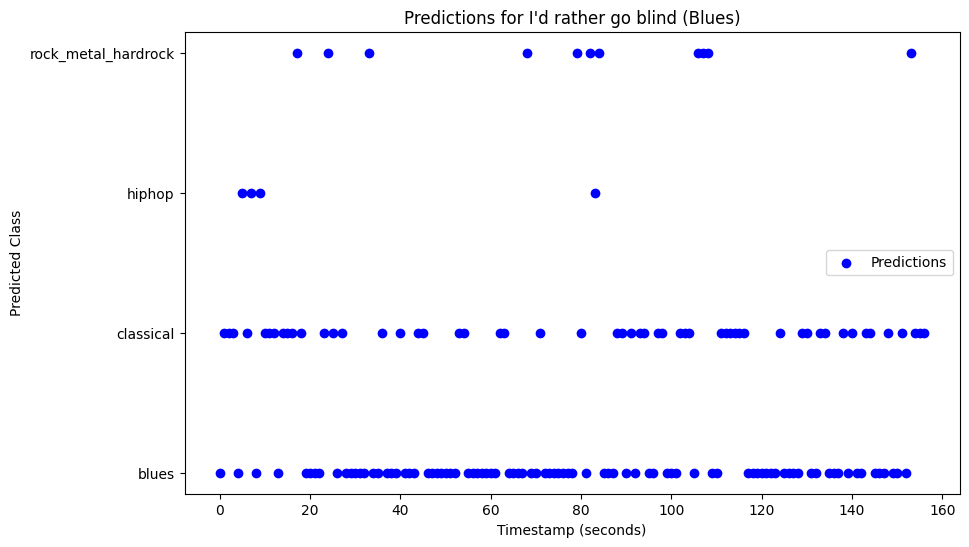

In [24]:
# Προβλέψεις του εκπαιδευμένου μοντέλου.

import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Για να μη βγάζει ένα Warning
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

def read_npy(filename):
    yt_test = np.load(filename)

    # Μετατροπή των numpy arrays σε torch tensors
    yt_test_tensor = torch.tensor(yt_test, dtype=torch.float32).unsqueeze(1)  # Προσθήκη διάστασης καναλιού

    # Δημιουργία TensorDatasets
    yt_test_dataset = TensorDataset(yt_test_tensor)

    # Δημιουργία DataLoaders
    batch_size = 16

    yt_test_loader = DataLoader(yt_test_dataset, batch_size=batch_size, shuffle=False)

    return yt_test_loader

# Αντίστροφο mapping
label_mapping = {
    0: "blues",
    1: "classical",
    2: "hiphop",
    3: "rock_metal_hardrock"
}

# Συνάρτηση για μετατροπή των προβλέψεων από αριθμούς σε strings
def map_predictions(predictions, label_mapping):
    return [label_mapping[pred] for pred in predictions]

# Συνάρτηση για εκτύπωση διαγράμματος
def plot_predictions(predictions, genre_name):
    mapped_predictions = map_predictions(predictions, label_mapping)
    timestamps = list(range(len(mapped_predictions)))
    plt.figure(figsize=(10, 6))
    plt.scatter(timestamps, mapped_predictions, label="Predictions", c='blue', marker='o')
    plt.xlabel("Timestamp (seconds)")
    plt.ylabel("Predicted Class")
    plt.title(f"Predictions for {genre_name}")
    plt.legend()
    plt.show()

classical1 = "https://www.youtube.com/watch?v=9E6b3swbnWg"
hiphop1 = "https://www.youtube.com/watch?v=meDdthGlbhI"
rock1 = "https://www.youtube.com/watch?v=OMaycNcPsHI"
blues1 = "https://www.youtube.com/watch?v=l45f28PzfCI"
classical2 = "https://www.youtube.com/watch?v=qxFwN2zjqEI"
hiphop2 = "https://www.youtube.com/watch?v=5qm8PH4xAss"
rock2 = "https://www.youtube.com/watch?v=XYZ9l85IEJs"
blues2 = "https://www.youtube.com/watch?v=Bcus42ihkTI"

yt_urls = [classical1, hiphop1, rock1, blues1, classical2, hiphop2, rock2, blues2]
genres = ["Nocturne (Classical)", "Yellow Tape (Hip Hop)", "Every You Every Me (Rock)", "How Blues Can Get You (Blues)", "Winter Snow (Classical)", "In Da Club (Hip Hop)", "Bad Medicine (Rock)", "I'd rather go blind (Blues)"]

for url, genre in zip(yt_urls, genres):
    youtube_to_melgram(url)
    yt_dataloader = read_npy("melgrams.npy")
    predictions = get_predictions(yt_dataloader, trained_model, device)
    plot_predictions(predictions, genre)